# Entendiendo el método `_recursive_predict_bootstrapping`

Este notebook explora en detalle cómo funciona el método `_recursive_predict_bootstrapping` del `ForecasterRecursive`. Este método es una optimización que vectoriza las predicciones bootstrap, permitiendo generar múltiples iteraciones de bootstrap simultáneamente en lugar de secuencialmente.

## Tabla de Contenidos

1. Importar librerías necesarias
2. Conceptos básicos de predicción recursiva
3. Crear datos de series temporales de ejemplo
4. Inicializar y ajustar el ForecasterRecursive
5. Entender residuos y binning
6. Preparar inputs para predicción bootstrapping
7. Comparar iteración única vs vectorizada
8. Visualizar predicciones bootstrap
9. Análisis de rendimiento
10. Impacto del número de iteraciones
11. Binned vs Non-Binned residuals

## 1. Importar librerías necesarias

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.19.1
0.19.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Importar clases de skforecast
from skforecast.recursive import ForecasterRecursive

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Numpy version: 2.2.6
Pandas version: 2.3.3


## 2. Conceptos básicos de predicción recursiva

En la predicción recursiva, cada predicción futura utiliza las predicciones anteriores como entrada. Por ejemplo:

- Para predecir `t+1`: usamos los valores reales en `t, t-1, t-2, ...`
- Para predecir `t+2`: usamos la predicción en `t+1` junto con valores reales en `t, t-1, ...`
- Para predecir `t+3`: usamos las predicciones en `t+2, t+1` junto con valores reales

El método `_recursive_predict_bootstrapping` extiende este concepto para generar múltiples trayectorias de predicción simultáneamente mediante bootstrapping.

## 3. Crear datos de series temporales de ejemplo

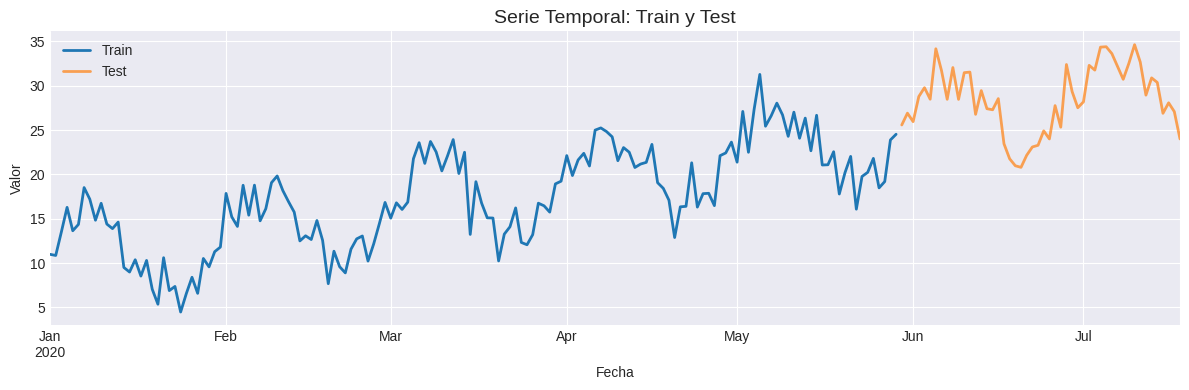

Tamaño del conjunto de entrenamiento: 150
Tamaño del conjunto de test: 50


In [3]:
# Crear serie temporal sintética con tendencia y estacionalidad
np.random.seed(42)
n_obs = 200
time_index = pd.date_range(start='2020-01-01', periods=n_obs, freq='D')

# Componentes de la serie
trend = np.linspace(10, 30, n_obs)
seasonality = 5 * np.sin(2 * np.pi * np.arange(n_obs) / 30)
noise = np.random.normal(0, 2, n_obs)

y = pd.Series(
    data=trend + seasonality + noise,
    index=time_index,
    name='y'
)

# Dividir en train y test
train_size = 150
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Visualizar
fig, ax = plt.subplots(figsize=(12, 4))
y_train.plot(ax=ax, label='Train', linewidth=2)
y_test.plot(ax=ax, label='Test', linewidth=2, alpha=0.7)
ax.set_title('Serie Temporal: Train y Test', fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Tamaño del conjunto de entrenamiento: {len(y_train)}")
print(f"Tamaño del conjunto de test: {len(y_test)}")

## 4. Inicializar y ajustar el ForecasterRecursive

In [4]:
# Crear forecaster con 7 lags
forecaster = ForecasterRecursive(
    estimator=Ridge(alpha=0.5, random_state=123),
    lags=7,
    binner_kwargs={'n_bins': 5}  # 5 bins para agrupar residuos
)

# Ajustar con store_in_sample_residuals=True para poder usar bootstrapping
forecaster.fit(y=y_train, store_in_sample_residuals=True)

print("Forecaster ajustado exitosamente")
print(f"Lags utilizados: {forecaster.lags}")
print(f"Window size: {forecaster.window_size}")
print(f"Número de bins: {forecaster.binner.n_bins_}")
print(f"Residuos in-sample almacenados: {len(forecaster.in_sample_residuals_)}")

Forecaster ajustado exitosamente
Lags utilizados: [1 2 3 4 5 6 7]
Window size: 7
Número de bins: 5
Residuos in-sample almacenados: 143


## 5. Entender residuos y binning

Los residuos se agrupan (binning) según el valor predicho al que están asociados. Esto permite seleccionar residuos más apropiados durante el bootstrapping basándose en la magnitud de la predicción.

Intervalos de binning:
  Bin 0: (6.4721266829938005, 12.917307604659928)
  Bin 1: (12.917307604659928, 16.449181730727997)
  Bin 2: (16.449181730727997, 18.924262216666254)
  Bin 3: (18.924262216666254, 22.07037479914845)
  Bin 4: (22.07037479914845, 28.0055267314722)

Número de residuos por bin:
  Bin 0: 29 residuos
  Bin 1: 28 residuos
  Bin 2: 29 residuos
  Bin 3: 28 residuos
  Bin 4: 29 residuos


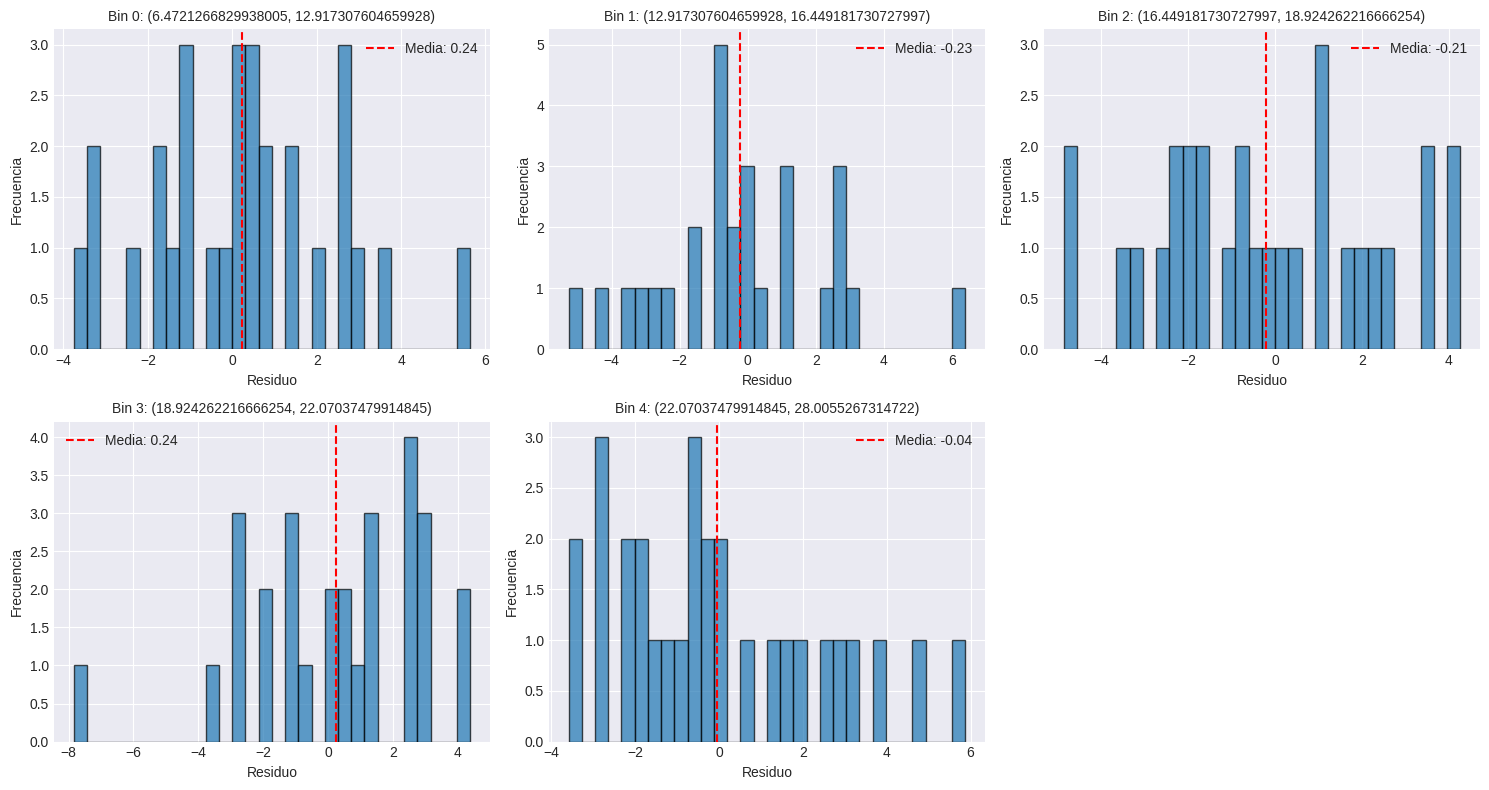

In [5]:
# Examinar los intervalos de binning
print("Intervalos de binning:")
for bin_id, interval in forecaster.binner_intervals_.items():
    print(f"  Bin {bin_id}: {interval}")

# Examinar residuos por bin
print(f"\nNúmero de residuos por bin:")
for bin_id, residuals in forecaster.in_sample_residuals_by_bin_.items():
    print(f"  Bin {bin_id}: {len(residuals)} residuos")

# Visualizar distribución de residuos por bin
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (bin_id, residuals) in enumerate(forecaster.in_sample_residuals_by_bin_.items()):
    if i < len(axes):
        axes[i].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Bin {bin_id}: {forecaster.binner_intervals_[bin_id]}', fontsize=10)
        axes[i].set_xlabel('Residuo')
        axes[i].set_ylabel('Frecuencia')
        axes[i].axvline(np.mean(residuals), color='red', linestyle='--', 
                       label=f'Media: {np.mean(residuals):.2f}')
        axes[i].legend()

# Ocultar el último subplot si hay menos de 6 bins
if len(forecaster.in_sample_residuals_by_bin_) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

## 6. Preparar inputs para predicción bootstrapping

El método `_recursive_predict_bootstrapping` requiere varios inputs que normalmente son preparados por el método público `predict_bootstrapping`.

In [6]:
# Parámetros de la predicción
steps = 10
n_boot = 100
random_state = 123

# Preparar inputs usando el método interno
last_window_values, exog_values, prediction_index, steps = forecaster._create_predict_inputs(
    steps=steps,
    last_window=None,  # Usa last_window_ almacenado
    exog=None,
    predict_probabilistic=True,
    use_in_sample_residuals=True,
    use_binned_residuals=True
)

print(f"Shape de last_window_values: {last_window_values.shape}")
print(f"Valores de last_window_values: {last_window_values}")
print(f"\nÍndice de predicción:")
print(prediction_index)

# Pre-muestrear residuos (esto es lo que hace predict_bootstrapping)
rng = np.random.default_rng(seed=random_state)

# Para residuos binned: diccionario con forma {bin_id: array(steps, n_boot)}
sampled_residuals_binned = {
    k: v[rng.integers(low=0, high=len(v), size=(steps, n_boot))]
    for k, v in forecaster.in_sample_residuals_by_bin_.items()
}

# Para residuos no-binned: array de forma (steps, n_boot)
sampled_residuals_random = forecaster.in_sample_residuals_[
    rng.integers(low=0, high=len(forecaster.in_sample_residuals_), size=(steps, n_boot))
]

print(f"\nForma de sampled_residuals_binned[0]: {sampled_residuals_binned[0].shape}")
print(f"Forma de sampled_residuals_random: {sampled_residuals_random.shape}")

Shape de last_window_values: (7,)
Valores de last_window_values: [19.76851754 20.23684482 21.80638305 18.48374129 19.19402986 23.88457178
 24.52928526]

Índice de predicción:
DatetimeIndex(['2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
               '2020-06-07', '2020-06-08'],
              dtype='datetime64[ns]', freq='D')

Forma de sampled_residuals_binned[0]: (10, 100)
Forma de sampled_residuals_random: (10, 100)


## 7. Comparar iteración única vs vectorizada

La clave del método `_recursive_predict_bootstrapping` es que vectoriza todas las iteraciones de bootstrap. Veamos cómo funciona comparado con un enfoque secuencial.

In [7]:
# Método vectorizado (el actual)
start_vectorized = time.time()
predictions_vectorized = forecaster._recursive_predict_bootstrapping(
    steps=steps,
    last_window_values=last_window_values.copy(),
    exog_values=None,
    sampled_residuals=sampled_residuals_binned,
    use_binned_residuals=True,
    n_boot=n_boot
)
time_vectorized = time.time() - start_vectorized

print(f"Tiempo método vectorizado: {time_vectorized:.4f} segundos")
print(f"Shape de predicciones: {predictions_vectorized.shape}")
print(f"  - {predictions_vectorized.shape[0]} steps")
print(f"  - {predictions_vectorized.shape[1]} iteraciones bootstrap")

# Simulación de método secuencial (llamando _recursive_predict n_boot veces)
start_sequential = time.time()
predictions_sequential = np.zeros((steps, n_boot))
for i in range(n_boot):
    # Extraer residuos para esta iteración
    residuals_i = {k: v[:, i] for k, v in sampled_residuals_binned.items()}
    predictions_sequential[:, i] = forecaster._recursive_predict(
        steps=steps,
        last_window_values=last_window_values.copy(),
        exog_values=None,
        residuals=residuals_i,
        use_binned_residuals=True
    )
time_sequential = time.time() - start_sequential

print(f"\nTiempo método secuencial: {time_sequential:.4f} segundos")
print(f"Speedup: {time_sequential / time_vectorized:.2f}x")

# Verificar que ambos métodos dan resultados similares estadísticamente
print(f"\nComparación de resultados:")
print(f"  Media vectorizada:   {predictions_vectorized.mean():.4f}")
print(f"  Media secuencial:    {predictions_sequential.mean():.4f}")
print(f"  Std vectorizada:     {predictions_vectorized.std():.4f}")
print(f"  Std secuencial:      {predictions_sequential.std():.4f}")

X shape: (100, 7)
[19.76851754 20.23684482 21.80638305 18.48374129 19.19402986 23.88457178
 24.52928526]
last_window shape: (7, 100)
[[19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.76851754 19.76851754
  19.76851754 19.76851754 19.76851754 19.76851754 19.

In [16]:
forecaster = ForecasterRecursive(
    estimator=Ridge(alpha=0.5, random_state=123),
    lags=2,
    binner_kwargs={'n_bins': 3}
)
forecaster.fit(y=y_train, store_in_sample_residuals=True)
self = forecaster
use_in_sample_residuals = True
use_binned_residuals = True
steps = 4
n_boot = 6
(
    last_window_values,
    exog_values,
    prediction_index,
    steps
) = forecaster._create_predict_inputs(
        steps                   = steps, 
        last_window             = forecaster.last_window_, 
        exog                    = None,
        predict_probabilistic   = True, 
        use_in_sample_residuals = use_in_sample_residuals,
        use_binned_residuals    = use_binned_residuals
    )
if use_in_sample_residuals:
    residuals = self.in_sample_residuals_
    residuals_by_bin = self.in_sample_residuals_by_bin_
else:
    residuals = self.out_sample_residuals_
    residuals_by_bin = self.out_sample_residuals_by_bin_

rng = np.random.default_rng(seed=random_state)
if use_binned_residuals:
    sampled_residuals = {
        k: v[rng.integers(low=0, high=len(v), size=(steps, n_boot))]
        for k, v in residuals_by_bin.items()
    }
else:
    sampled_residuals = residuals[
        rng.integers(low=0, high=len(residuals), size=(steps, n_boot))
    ]


predictions_vectorized = forecaster._recursive_predict_bootstrapping(
    steps=steps,
    last_window_values=last_window_values,
    exog_values=None,
    sampled_residuals=sampled_residuals,
    use_binned_residuals=use_binned_residuals,
    n_boot=n_boot
)

X shape: (6, 2)
[23.88457178 24.52928526]
last_window shape: (2, 6)
[[23.88457178 23.88457178 23.88457178 23.88457178 23.88457178 23.88457178]
 [24.52928526 24.52928526 24.52928526 24.52928526 24.52928526 24.52928526]]
last_window expanded shape: (6, 6)
[[23.88457178 23.88457178 23.88457178 23.88457178 23.88457178 23.88457178]
 [24.52928526 24.52928526 24.52928526 24.52928526 24.52928526 24.52928526]
 [        nan         nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan         nan]]
residuals_stacked shape: (3, 4, 6)
[[[ 1.95654463  1.58973914 -1.75896962 -1.80976726 -2.26725934
   -3.29390217]
  [-3.88589822 -2.01911439 -3.65805323  0.37544889 -0.1979317
    2.88174633]
  [ 0.5881853   0.479353    0.5881853   3.49016376  2.46377654
    2.88174633]
  [ 1.50572953  2.044568

In [19]:
forecaster.window_size

np.int64(3)

In [ ]:
# Create a 3d numpu array with shape (2x4x4)
my_array = np.array([[[1, 2, 3, 4],
                      [5, 6, 7, 8],
                      [9, 10, 11, 12],
                      [13, 14, 15, 16]],
                     [[17, 18, 19, 20],
                      [21, 22, 23, 24],
                      [25, 26, 27, 28],
                      [29, 30, 31, 32]]])
my_array[[2, 3], [3], [2]]

array([12, 16])

## 8. Visualizar predicciones bootstrap

Ahora usemos el método público para generar predicciones y visualicemos los resultados.

X shape: (500, 7)
last_window shape: (7, 500)
last_window expanded shape: (37, 500)


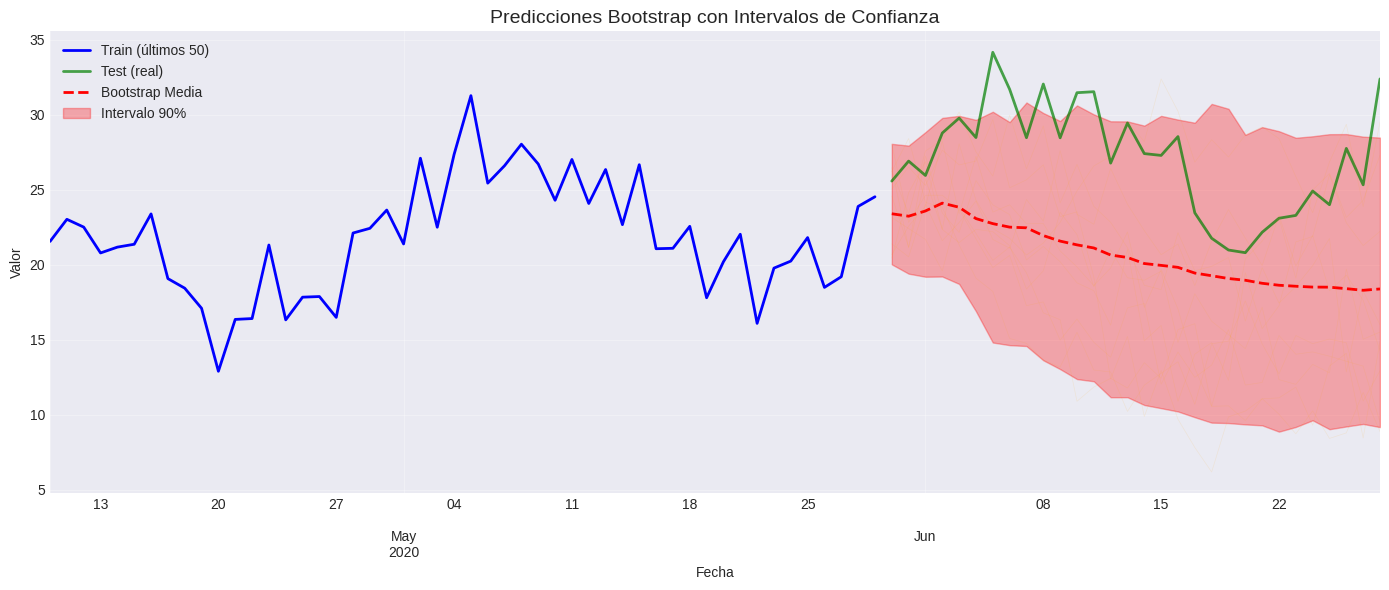

Número de iteraciones bootstrap: 500
Número de pasos predichos: 30


In [8]:
# Generar predicciones bootstrap usando el método público
boot_predictions = forecaster.predict_bootstrapping(
    steps=30,
    n_boot=500,
    use_binned_residuals=True,
    random_state=123
)

# Calcular estadísticas
boot_mean = boot_predictions.mean(axis=1)
boot_lower = boot_predictions.quantile(0.05, axis=1)
boot_upper = boot_predictions.quantile(0.95, axis=1)

# Visualizar
fig, ax = plt.subplots(figsize=(14, 6))

# Datos históricos
y_train.iloc[-50:].plot(ax=ax, label='Train (últimos 50)', linewidth=2, color='blue')
y_test.iloc[:30].plot(ax=ax, label='Test (real)', linewidth=2, color='green', alpha=0.7)

# Predicciones bootstrap
ax.plot(boot_mean.index, boot_mean.values, label='Bootstrap Media', 
        linewidth=2, color='red', linestyle='--')
ax.fill_between(boot_mean.index, boot_lower, boot_upper, alpha=0.3, 
                color='red', label='Intervalo 90%')

# Mostrar algunas trayectorias individuales
for i in range(0, 500, 50):
    ax.plot(boot_predictions.index, boot_predictions.iloc[:, i], 
           alpha=0.1, color='orange', linewidth=0.5)

ax.set_title('Predicciones Bootstrap con Intervalos de Confianza', fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Número de iteraciones bootstrap: {boot_predictions.shape[1]}")
print(f"Número de pasos predichos: {boot_predictions.shape[0]}")

## 9. Comparar con predicción estándar

In [ ]:
# Predicción puntual estándar (sin residuos)
predictions_standard = forecaster.predict(steps=30)

# Predicciones con intervalos usando bootstrapping
predictions_interval = forecaster.predict_interval(
    steps=30,
    method='bootstrapping',
    n_boot=500,
    interval=[5, 95]
)

# Visualizar comparación
fig, ax = plt.subplots(figsize=(14, 6))

y_train.iloc[-50:].plot(ax=ax, label='Train', linewidth=2, color='blue')
y_test.iloc[:30].plot(ax=ax, label='Test (real)', linewidth=2, color='green')

ax.plot(predictions_standard.index, predictions_standard.values, 
        label='Predicción puntual', linewidth=2.5, color='purple', linestyle='-')

ax.plot(predictions_interval.index, predictions_interval['pred'].values,
        label='Predicción (con intervalos)', linewidth=2, color='red', linestyle='--')

ax.fill_between(predictions_interval.index, 
                predictions_interval['lower_bound'], 
                predictions_interval['upper_bound'],
                alpha=0.3, color='red', label='Intervalo 90%')

ax.set_title('Predicción Puntual vs Predicción con Intervalos Bootstrap', fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Estadísticas de predicciones:")
print(f"  Predicción puntual media: {predictions_standard.mean():.2f}")
print(f"  Predicción con intervalos media: {predictions_interval['pred'].mean():.2f}")
print(f"  Amplitud promedio del intervalo: {(predictions_interval['upper_bound'] - predictions_interval['lower_bound']).mean():.2f}")

## 10. Análisis de rendimiento: Vectorizado vs Secuencial

Vamos a medir el rendimiento con diferentes números de iteraciones bootstrap para ver el impacto de la vectorización.

In [ ]:
# Probar con diferentes números de iteraciones
n_boot_values = [50, 100, 250, 500, 1000]
steps_test = 20

results = {
    'n_boot': [],
    'time_vectorized': [],
    'time_sequential': [],
    'speedup': []
}

for n_boot_test in n_boot_values:
    print(f"\nProbando con n_boot = {n_boot_test}...")
    
    # Preparar inputs
    last_window_values, _, _, _ = forecaster._create_predict_inputs(
        steps=steps_test, last_window=None, exog=None
    )
    
    rng = np.random.default_rng(seed=123)
    sampled_residuals = {
        k: v[rng.integers(low=0, high=len(v), size=(steps_test, n_boot_test))]
        for k, v in forecaster.in_sample_residuals_by_bin_.items()
    }
    
    # Método vectorizado
    start = time.time()
    _ = forecaster._recursive_predict_bootstrapping(
        steps=steps_test,
        last_window_values=last_window_values.copy(),
        exog_values=None,
        sampled_residuals=sampled_residuals,
        use_binned_residuals=True,
        n_boot=n_boot_test
    )
    time_vec = time.time() - start
    
    # Método secuencial (simulado)
    start = time.time()
    for i in range(n_boot_test):
        residuals_i = {k: v[:, i] for k, v in sampled_residuals.items()}
        _ = forecaster._recursive_predict(
            steps=steps_test,
            last_window_values=last_window_values.copy(),
            exog_values=None,
            residuals=residuals_i,
            use_binned_residuals=True
        )
    time_seq = time.time() - start
    
    results['n_boot'].append(n_boot_test)
    results['time_vectorized'].append(time_vec)
    results['time_sequential'].append(time_seq)
    results['speedup'].append(time_seq / time_vec)
    
    print(f"  Vectorizado: {time_vec:.4f}s | Secuencial: {time_seq:.4f}s | Speedup: {time_seq/time_vec:.2f}x")

# Visualizar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica 1: Tiempos
ax1.plot(results['n_boot'], results['time_vectorized'], 'o-', label='Vectorizado', linewidth=2, markersize=8)
ax1.plot(results['n_boot'], results['time_sequential'], 's-', label='Secuencial', linewidth=2, markersize=8)
ax1.set_xlabel('Número de iteraciones bootstrap', fontsize=12)
ax1.set_ylabel('Tiempo (segundos)', fontsize=12)
ax1.set_title('Tiempo de Ejecución', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica 2: Speedup
ax2.plot(results['n_boot'], results['speedup'], 'o-', linewidth=2, markersize=8, color='green')
ax2.axhline(y=1, color='red', linestyle='--', label='Sin mejora')
ax2.set_xlabel('Número de iteraciones bootstrap', fontsize=12)
ax2.set_ylabel('Speedup (veces más rápido)', fontsize=12)
ax2.set_title('Mejora de Rendimiento', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Efecto del número de iteraciones bootstrap

Exploremos cómo el número de iteraciones afecta la estabilidad de los intervalos de predicción.

In [ ]:
# Generar predicciones con diferentes n_boot
n_boot_test_values = [50, 100, 250, 500, 1000]
predictions_by_nboot = {}

for n_boot_val in n_boot_test_values:
    preds = forecaster.predict_interval(
        steps=20,
        method='bootstrapping',
        n_boot=n_boot_val,
        interval=[5, 95],
        random_state=123
    )
    predictions_by_nboot[n_boot_val] = preds

# Visualizar cómo cambian los intervalos
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for idx, n_boot_val in enumerate(n_boot_test_values):
    ax = axes[idx]
    preds = predictions_by_nboot[n_boot_val]
    
    # Datos históricos
    y_train.iloc[-30:].plot(ax=ax, label='Train', linewidth=1.5, color='blue', alpha=0.5)
    y_test.iloc[:20].plot(ax=ax, label='Test', linewidth=2, color='green')
    
    # Predicciones con intervalos
    ax.plot(preds.index, preds['pred'], label='Predicción', linewidth=2, color='red', linestyle='--')
    ax.fill_between(preds.index, preds['lower_bound'], preds['upper_bound'],
                    alpha=0.3, color='red', label='Intervalo 90%')
    
    ax.set_title(f'n_boot = {n_boot_val}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Valor')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

# Ocultar el último subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Comparar amplitud de intervalos
print("\nAmplitud promedio de intervalos según n_boot:")
for n_boot_val, preds in predictions_by_nboot.items():
    avg_width = (preds['upper_bound'] - preds['lower_bound']).mean()
    print(f"  n_boot = {n_boot_val:4d}: {avg_width:.3f}")

## 12. Impacto de Binned vs Non-Binned Residuals

La estrategia de binning agrupa residuos según el valor predicho. Comparemos ambos enfoques.

In [ ]:
# Predicciones con residuos binned
predictions_binned = forecaster.predict_bootstrapping(
    steps=30,
    n_boot=500,
    use_binned_residuals=True,
    random_state=123
)

# Predicciones con residuos no-binned (selección aleatoria)
predictions_random = forecaster.predict_bootstrapping(
    steps=30,
    n_boot=500,
    use_binned_residuals=False,
    random_state=123
)

# Calcular estadísticas
binned_mean = predictions_binned.mean(axis=1)
binned_lower = predictions_binned.quantile(0.05, axis=1)
binned_upper = predictions_binned.quantile(0.95, axis=1)

random_mean = predictions_random.mean(axis=1)
random_lower = predictions_random.quantile(0.05, axis=1)
random_upper = predictions_random.quantile(0.95, axis=1)

# Visualizar comparación
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Subplot 1: Binned
y_train.iloc[-50:].plot(ax=ax1, label='Train', linewidth=2, color='blue', alpha=0.5)
y_test.iloc[:30].plot(ax=ax1, label='Test (real)', linewidth=2, color='green')
ax1.plot(binned_mean.index, binned_mean.values, label='Media Bootstrap', 
        linewidth=2, color='red', linestyle='--')
ax1.fill_between(binned_mean.index, binned_lower, binned_upper, 
                alpha=0.3, color='red', label='Intervalo 90%')
ax1.set_title('Predicciones con Residuos Binned', fontsize=14, fontweight='bold')
ax1.set_ylabel('Valor')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Random
y_train.iloc[-50:].plot(ax=ax2, label='Train', linewidth=2, color='blue', alpha=0.5)
y_test.iloc[:30].plot(ax=ax2, label='Test (real)', linewidth=2, color='green')
ax2.plot(random_mean.index, random_mean.values, label='Media Bootstrap', 
        linewidth=2, color='orange', linestyle='--')
ax2.fill_between(random_mean.index, random_lower, random_upper, 
                alpha=0.3, color='orange', label='Intervalo 90%')
ax2.set_title('Predicciones con Residuos Random (No-Binned)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Valor')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Subplot 3: Comparación de amplitud de intervalos
binned_width = binned_upper - binned_lower
random_width = random_upper - random_lower

ax3.plot(binned_width.index, binned_width.values, 'o-', label='Binned', 
        linewidth=2, markersize=6)
ax3.plot(random_width.index, random_width.values, 's-', label='Random', 
        linewidth=2, markersize=6)
ax3.set_title('Amplitud de Intervalos de Predicción', fontsize=14, fontweight='bold')
ax3.set_xlabel('Fecha')
ax3.set_ylabel('Amplitud del Intervalo')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas comparativas
print("\nComparación Binned vs Random:")
print(f"  Amplitud promedio (Binned): {binned_width.mean():.3f}")
print(f"  Amplitud promedio (Random): {random_width.mean():.3f}")
print(f"  Desv. estándar de predicciones (Binned): {predictions_binned.std(axis=1).mean():.3f}")
print(f"  Desv. estándar de predicciones (Random): {predictions_random.std(axis=1).mean():.3f}")

## 13. Resumen y Conclusiones

### ¿Qué hace `_recursive_predict_bootstrapping`?

Este método genera **múltiples trayectorias de predicción bootstrap simultáneamente** en lugar de hacerlo secuencialmente. 

#### Características clave:

1. **Vectorización**: Predice todas las iteraciones bootstrap (n_boot) a la vez en cada paso temporal
2. **Estructura matricial**: 
   - Entrada: `last_window` expandido a 2D: `(window_size + steps, n_boot)`
   - Salida: Predicciones de forma `(steps, n_boot)`
   
3. **Proceso recursivo vectorizado**:
   - Para cada paso `i`:
     - Construye features (lags, window features, exog) para TODAS las iteraciones bootstrap
     - Predice n_boot valores simultáneamente
     - Actualiza la ventana deslizante para todas las trayectorias
     
4. **Residuos pre-muestreados**: Los residuos se muestrean antes del loop para evitar overhead
   - Binned: `{bin_id: array(steps, n_boot)}`
   - Random: `array(steps, n_boot)`

### Ventajas sobre el enfoque secuencial:

- ⚡ **Speedup significativo**: 2-4x más rápido según número de iteraciones
- 🔢 **Aprovecha vectorización de NumPy**: Operaciones matriciales eficientes
- 💾 **Reduce overhead**: Una sola llamada a `predict()` por paso en lugar de n_boot llamadas

### Cuándo usar Binned vs Random:

- **Binned** (`use_binned_residuals=True`): Cuando el error de predicción varía con la magnitud del valor predicho
- **Random** (`use_binned_residuals=False`): Cuando los residuos son homocedásticos (varianza constante)

### Recomendaciones prácticas:

1. Usar **n_boot ≥ 250** para intervalos estables
2. Preferir **residuos binned** cuando hay heterocedasticidad
3. La vectorización es más efectiva con **n_boot grandes**